In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
#df = Imputer().fit_transform(df)
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize

In [2]:
#获取行业分类
industrys = DP.get_industrys()

In [14]:
industry='all'
#取行业内股票数据
data = DP.get_daily_data(industry=industry, fields=['open', 'high', 'low', 'close', ''])
OPEN = data['open']
HIGH = data['high']
LOW = data['low']
CLOSE = data['close']

#补缺
#CLOSE.fillna(method='ffill', inplace=True)
#OPEN.fillna(value=CLOSE, inplace=True)
#HIGH.fillna(value=CLOSE, inplace=True)
#LOW.fillna(value=CLOSE, inplace=True)

In [182]:
#上市20日空缺
n_shangshi = 20
for i in range(len(OPEN.columns)):
    shangshi = np.where(np.diff(np.where(OPEN.iloc[:,0].isna())[0])!=1)[0][0]
    OPEN.iloc[shangshi:shangshi+20, i] = np.nan
    HIGH.iloc[shangshi:shangshi+20, i] = np.nan
    LOW.iloc[shangshi:shangshi+20, i] = np.nan
    CLOSE.iloc[shangshi:shangshi+20, i] = np.nan

In [183]:
#计算收益率，日内收益率，隔夜收益率
ror = CLOSE / CLOSE.shift() - 1
r_rinei = CLOSE / OPEN - 1
r_geye = OPEN / CLOSE.shift() - 1
rh = HIGH / OPEN - 1
rl = LOW / OPEN - 1

In [184]:
#划分训练测试集
begin_train = '2015-01-01'
end_train = '2019-01-01'
begin_test = '2019-01-01'
end_test = '2021-01-01'

OPEN_train = OPEN.loc[(begin_train < ror.index) & (ror.index < end_train), :]
HIGH_train = HIGH.loc[(begin_train < ror.index) & (ror.index < end_train), :]
LOW_train = LOW.loc[(begin_train < ror.index) & (ror.index < end_train), :]
CLOSE_train = CLOSE.loc[(begin_train < ror.index) & (ror.index < end_train), :]

OPEN_test = OPEN.loc[(begin_test < ror.index) & (ror.index < end_test), :]
HIGH_test = HIGH.loc[(begin_test < ror.index) & (ror.index < end_test), :]
LOW_test = LOW.loc[(begin_test < ror.index) & (ror.index < end_test), :]
CLOSE_test = CLOSE.loc[(begin_test < ror.index) & (ror.index < end_test), :]

rh_train = rh.loc[(begin_train < ror.index) & (ror.index < end_train), :]
rl_train = rl.loc[(begin_train < ror.index) & (ror.index < end_train), :]

rh_test = rh.loc[(begin_test < ror.index) & (ror.index < end_test), :]
rl_test = rl.loc[(begin_test < ror.index) & (ror.index < end_test), :]

ror_train = ror.loc[(begin_train < ror.index) & (ror.index < end_train), :]
ror_test = ror.loc[(begin_test < ror.index) & (ror.index < end_test), :]
r_rinei_train = r_rinei.loc[(begin_train < r_rinei.index) & (r_rinei.index < end_train), :]
r_rinei_test = r_rinei.loc[(begin_test < r_rinei.index) & (r_rinei.index < end_test), :]
r_geye_train = r_geye.loc[(begin_train < r_geye.index) & (r_geye.index < end_train), :]
r_geye_test = r_geye.loc[(begin_test < r_geye.index) & (r_geye.index < end_test), :]

In [185]:
ror_train.iloc[0,:].notna().mean()

0.6149933065595716

In [186]:
#数据清洗
#r_rinei_train = r_rinei_train.loc[:, ror_train.iloc[0,:].notna()]
#r_geye_train = r_geye_train.loc[:, ror_train.iloc[0,:].notna()]
#ror_train = ror_train.loc[:, ror_train.iloc[0,:].notna()]
#ror_train.fillna(value=ror_train.mean(0), inplace=True)
#r_rinei_train.fillna(value=r_rinei_train.mean(0), inplace=True)
#r_rinei_test.fillna(value=r_rinei_test.mean(0), inplace=True)
#imp = SimpleImputer(strategy='mean')
#ror_train = DataFrame(imp.fit_transform(ror_train))
#r_rinei_train = DataFrame(imp.fit_transform(r_rinei_train))
#r_geye_train = DataFrame(imp.fit_transform(r_geye_train))

In [187]:
#预测未来n天
n = 1

In [188]:
#构造因子
#y_train = centralize(ror_train.rolling(n).sum().shift(-n+1) - r_geye_train)
y_train = centralize(r_rinei_train)

x1_train = centralize(r_rinei_train.shift(1))
x2_train = centralize(r_rinei_train.rolling(2).mean().shift(2))
x3_train = centralize(r_rinei_train.rolling(2).mean().shift(4))
x4_train = centralize(r_rinei_train.rolling(5).mean().shift(6))
x5_train = centralize(r_rinei_train.rolling(10).mean().shift(11))
x6_train = centralize(r_rinei_train.rolling(20).mean().shift(21))
x7_train = centralize(r_rinei_train.rolling(20).mean().shift(41))

z1_train = centralize(r_geye_train.shift(1))
z2_train = centralize(r_geye_train.rolling(2).mean().shift(2))
z3_train = centralize(r_geye_train.rolling(2).mean().shift(4))
z4_train = centralize(r_geye_train.rolling(5).mean().shift(6))
z5_train = centralize(r_geye_train.rolling(10).mean().shift(11))
z6_train = centralize(r_geye_train.rolling(20).mean().shift(21))
z7_train = centralize(r_geye_train.rolling(20).mean().shift(41))

u1_train = centralize(ror_train.shift(1))
u2_train = centralize(ror_train.rolling(2).mean().shift(2))
u3_train = centralize(ror_train.rolling(2).mean().shift(4))
u4_train = centralize(ror_train.rolling(5).mean().shift(6))
u5_train = centralize(ror_train.rolling(10).mean().shift(11))
u6_train = centralize(ror_train.rolling(20).mean().shift(21))
u7_train = centralize(ror_train.rolling(20).mean().shift(41))

h1_train = centralize(rh_train.shift(1))
h2_train = centralize(rh_train.rolling(2).mean().shift(2))
h3_train = centralize(rh_train.rolling(2).mean().shift(4))
h4_train = centralize(rh_train.rolling(5).mean().shift(6))
h5_train = centralize(rh_train.rolling(10).mean().shift(11))
h6_train = centralize(rh_train.rolling(20).mean().shift(21))
h7_train = centralize(rh_train.rolling(20).mean().shift(41))

l1_train = centralize(rl_train.shift(1))
l2_train = centralize(rl_train.rolling(2).mean().shift(2))
l3_train = centralize(rl_train.rolling(2).mean().shift(4))
l4_train = centralize(rl_train.rolling(5).mean().shift(6))
l5_train = centralize(rl_train.rolling(10).mean().shift(11))
l6_train = centralize(rl_train.rolling(20).mean().shift(21))
l7_train = centralize(rl_train.rolling(20).mean().shift(41))

df_train = DataFrame({'y':y_train.values.flatten(),
               'x1':x1_train.values.flatten(),
               'x2':x2_train.values.flatten(),
               'x3':x3_train.values.flatten(),
               'x4':x4_train.values.flatten(),
               'x5':x5_train.values.flatten(),
               'x6':x6_train.values.flatten(),
               'x7':x7_train.values.flatten(),
               'z1':z1_train.values.flatten(),
               'z2':z2_train.values.flatten(),
               'z3':z3_train.values.flatten(),
               'z4':z4_train.values.flatten(),
               'z5':z5_train.values.flatten(),
               'z6':z6_train.values.flatten(),
               'z7':z7_train.values.flatten(),
               'u1':u1_train.values.flatten(),
               'u2':u2_train.values.flatten(),
               'u3':u3_train.values.flatten(),
               'u4':u4_train.values.flatten(),
               'u5':u5_train.values.flatten(),
               'u6':u6_train.values.flatten(),
               'u7':u7_train.values.flatten(),
               'h1':h1_train.values.flatten(),
               'h2':h2_train.values.flatten(),
               'h3':h3_train.values.flatten(),
               'h4':h4_train.values.flatten(),
               'h5':h5_train.values.flatten(),
               'h6':h6_train.values.flatten(),
               'h7':h7_train.values.flatten(),
               'l1':l1_train.values.flatten(),
               'l2':l2_train.values.flatten(),
               'l3':l3_train.values.flatten(),
               'l4':l4_train.values.flatten(),
               'l5':l5_train.values.flatten(),
               'l6':l6_train.values.flatten(),
               'l7':l7_train.values.flatten(),
                     })

#y_test = centralize(ror_test.rolling(n).sum().shift(-n+1) - r_geye_test)
y_test = centralize(r_rinei_test)

x1_test = centralize(r_rinei_test.shift(1))
x2_test = centralize(r_rinei_test.rolling(2).mean().shift(2))
x3_test = centralize(r_rinei_test.rolling(2).mean().shift(4))
x4_test = centralize(r_rinei_test.rolling(5).mean().shift(6))
x5_test = centralize(r_rinei_test.rolling(10).mean().shift(11))
x6_test = centralize(r_rinei_test.rolling(20).mean().shift(21))
x7_test = centralize(r_rinei_test.rolling(20).mean().shift(41))

z1_test = centralize(r_geye_test.shift(1))
z2_test = centralize(r_geye_test.rolling(2).mean().shift(2))
z3_test = centralize(r_geye_test.rolling(2).mean().shift(4))
z4_test = centralize(r_geye_test.rolling(5).mean().shift(6))
z5_test = centralize(r_geye_test.rolling(10).mean().shift(11))
z6_test = centralize(r_geye_test.rolling(20).mean().shift(21))
z7_test = centralize(r_geye_test.rolling(20).mean().shift(41))

u1_test = centralize(ror_test.shift(1))
u2_test = centralize(ror_test.rolling(2).mean().shift(2))
u3_test = centralize(ror_test.rolling(2).mean().shift(4))
u4_test = centralize(ror_test.rolling(5).mean().shift(6))
u5_test = centralize(ror_test.rolling(10).mean().shift(11))
u6_test = centralize(ror_test.rolling(20).mean().shift(21))
u7_test = centralize(ror_test.rolling(20).mean().shift(41))

h1_test = centralize(rh_test.shift(1))
h2_test = centralize(rh_test.rolling(2).mean().shift(2))
h3_test = centralize(rh_test.rolling(2).mean().shift(4))
h4_test = centralize(rh_test.rolling(5).mean().shift(6))
h5_test = centralize(rh_test.rolling(10).mean().shift(11))
h6_test = centralize(rh_test.rolling(20).mean().shift(21))
h7_test = centralize(rh_test.rolling(20).mean().shift(41))

l1_test = centralize(rl_test.shift(1))
l2_test = centralize(rl_test.rolling(2).mean().shift(2))
l3_test = centralize(rl_test.rolling(2).mean().shift(4))
l4_test = centralize(rl_test.rolling(5).mean().shift(6))
l5_test = centralize(rl_test.rolling(10).mean().shift(11))
l6_test = centralize(rl_test.rolling(20).mean().shift(21))
l7_test = centralize(rl_test.rolling(20).mean().shift(41))


df_test = DataFrame({'y':y_test.values.flatten(),
               'x1':x1_test.values.flatten(),
               'x2':x2_test.values.flatten(),
               'x3':x3_test.values.flatten(),
               'x4':x4_test.values.flatten(),
               'x5':x5_test.values.flatten(),
               'x6':x6_test.values.flatten(),
               'x7':x7_test.values.flatten(),
               'z1':z1_test.values.flatten(),
               'z2':z2_test.values.flatten(),
               'z3':z3_test.values.flatten(),
               'z4':z4_test.values.flatten(),
               'z5':z5_test.values.flatten(),
               'z6':z6_test.values.flatten(),
               'z7':z7_test.values.flatten(),
               'u1':u1_test.values.flatten(),
               'u2':u2_test.values.flatten(),
               'u3':u3_test.values.flatten(),
               'u4':u4_test.values.flatten(),
               'u5':u5_test.values.flatten(),
               'u6':u6_test.values.flatten(),
               'u7':u7_test.values.flatten(),
               'h1':h1_test.values.flatten(),
               'h2':h2_test.values.flatten(),
               'h3':h3_test.values.flatten(),
               'h4':h4_test.values.flatten(),
               'h5':h5_test.values.flatten(),
               'h6':h6_test.values.flatten(),
               'h7':h7_test.values.flatten(),
               'l1':l1_test.values.flatten(),
               'l2':l2_test.values.flatten(),
               'l3':l3_test.values.flatten(),
               'l4':l4_test.values.flatten(),
               'l5':l5_test.values.flatten(),
               'l6':l6_test.values.flatten(),
               'l7':l7_test.values.flatten(),
                    })

In [189]:
#y_train[(LOW_train==HIGH_train) & ((OPEN_train-CLOSE_train.shift())>1e-6)] = np.nan
#ror_test = ror_test.shift(-1)
#ror_test[(LOW_test==HIGH_test) & ((OPEN_test-CLOSE_test.shift())>1e-6)] = 0
#ror_test = ror_test.shift()

In [190]:
#ror_test.loc[:,'000698.SZ']

In [191]:
model = smf.ols('y~x1+z1+u2+u3+u4+u5+u6+u7+h1+h2+h3+h4+h5+h6+h7+l1+l2+l3+l4+l5+l6+l7', data=df_train).fit()
model.tvalues

Intercept    -3.403016
x1           -7.560563
z1           11.239295
u2           -3.231602
u3          -10.785625
u4           -6.904010
u5          -19.108859
u6           -8.066681
u7           -1.853841
h1           33.755554
h2           14.454938
h3            1.177600
h4           11.567776
h5           11.261474
h6            6.781223
h7            2.854799
l1          -14.961241
l2            1.921880
l3           -0.452259
l4            5.351095
l5            8.352224
l6            4.211971
l7            9.731838
dtype: float64

300612.SZ    0.006969
000612.SZ    0.005133
300052.SZ    0.004900
002753.SZ    0.004499
600071.SH    0.004450
300816.SZ    0.004406
002977.SZ    0.004301
300293.SZ    0.004207
603976.SH    0.004118
000592.SZ    0.004116
Name: 2020-07-09 00:00:00, dtype: float64


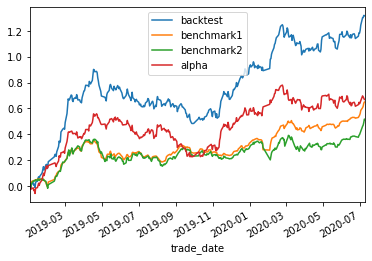

In [192]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test.iloc[:,1:].fillna(0)).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
position = (y_hat.gt(y_hat.quantile(0.999, 1), 0))
#position = DataFrame({s:})
#position = y_hat.gt(y_hat.max(1), 0)
ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()
benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
ror_test.mean(1).cumsum().plot()
(ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()).plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha'])
print(y_hat.iloc[-m,:].sort_values(ascending=False).dropna().iloc[:10])

In [193]:
DataFrame({i:list(position.columns[position.loc[i,:]]) for i in position.index[1:]}).T.iloc[-20:,:]

,0,1,2,3
2020-06-11,600086.SH,002989.SZ,300431.SZ,603703.SH
2020-06-12,600086.SH,300090.SZ,300431.SZ,600734.SH
2020-06-15,002981.SZ,300090.SZ,300178.SZ,603277.SH
2020-06-16,601969.SH,300090.SZ,002208.SZ,000011.SZ
2020-06-17,000612.SZ,600146.SH,603439.SH,300439.SZ
2020-06-18,300641.SZ,600146.SH,600086.SH,300612.SZ
2020-06-19,300277.SZ,300058.SZ,300392.SZ,600984.SH
2020-06-22,002827.SZ,300791.SZ,300612.SZ,601777.SH
2020-06-23,002827.SZ,000638.SZ,000416.SZ,300512.SZ
2020-06-24,000612.SZ,300518.SZ,603703.SH,601777.SH


In [1058]:
x1_test = centralize(r_rinei_test)
x2_test = centralize(r_rinei_test.rolling(2).mean().shift(1))
x3_test = centralize(r_rinei_test.rolling(2).mean().shift(3))
x4_test = centralize(r_rinei_test.rolling(5).mean().shift(5))
x5_test = centralize(r_rinei_test.rolling(10).mean().shift(10))
x6_test = centralize(r_rinei_test.rolling(20).mean().shift(20))
x7_test = centralize(r_rinei_test.rolling(20).mean().shift(40))

z1_test = centralize(r_geye_test)
z2_test = centralize(r_geye_test.rolling(2).mean().shift(1))
z3_test = centralize(r_geye_test.rolling(2).mean().shift(3))
z4_test = centralize(r_geye_test.rolling(5).mean().shift(5))
z5_test = centralize(r_geye_test.rolling(10).mean().shift(10))
z6_test = centralize(r_geye_test.rolling(20).mean().shift(20))
z7_test = centralize(r_geye_test.rolling(20).mean().shift(40))

u1_test = centralize(ror_test)
u2_test = centralize(ror_test.rolling(2).mean().shift(1))
u3_test = centralize(ror_test.rolling(2).mean().shift(3))
u4_test = centralize(ror_test.rolling(5).mean().shift(5))
u5_test = centralize(ror_test.rolling(10).mean().shift(10))
u6_test = centralize(ror_test.rolling(20).mean().shift(20))
u7_test = centralize(ror_test.rolling(20).mean().shift(40))

h1_test = centralize(rh_test)
h2_test = centralize(rh_test.rolling(2).mean().shift(1))
h3_test = centralize(rh_test.rolling(2).mean().shift(3))
h4_test = centralize(rh_test.rolling(5).mean().shift(5))
h5_test = centralize(rh_test.rolling(10).mean().shift(10))
h6_test = centralize(rh_test.rolling(20).mean().shift(20))
h7_test = centralize(rh_test.rolling(20).mean().shift(40))

l1_test = centralize(rl_test)
l2_test = centralize(rl_test.rolling(2).mean().shift(1))
l3_test = centralize(rl_test.rolling(2).mean().shift(3))
l4_test = centralize(rl_test.rolling(5).mean().shift(5))
l5_test = centralize(rl_test.rolling(10).mean().shift(10))
l6_test = centralize(rl_test.rolling(20).mean().shift(20))
l7_test = centralize(rl_test.rolling(20).mean().shift(40))

df_test = DataFrame({'y':y_test.values.flatten(),
               'x1':x1_test.values.flatten(),
               'x2':x2_test.values.flatten(),
               'x3':x3_test.values.flatten(),
               'x4':x4_test.values.flatten(),
               'x5':x5_test.values.flatten(),
               'x6':x6_test.values.flatten(),
               'x7':x7_test.values.flatten(),
               'z1':z1_test.values.flatten(),
               'z2':z2_test.values.flatten(),
               'z3':z3_test.values.flatten(),
               'z4':z4_test.values.flatten(),
               'z5':z5_test.values.flatten(),
               'z6':z6_test.values.flatten(),
               'z7':z7_test.values.flatten(),
               'u1':u1_test.values.flatten(),
               'u2':u2_test.values.flatten(),
               'u3':u3_test.values.flatten(),
               'u4':u4_test.values.flatten(),
               'u5':u5_test.values.flatten(),
               'u6':u6_test.values.flatten(),
               'u7':u7_test.values.flatten(),
               'h1':h1_test.values.flatten(),
               'h2':h2_test.values.flatten(),
               'h3':h3_test.values.flatten(),
               'h4':h4_test.values.flatten(),
               'h5':h5_test.values.flatten(),
               'h6':h6_test.values.flatten(),
               'h7':h7_test.values.flatten(),
               'l1':l1_test.values.flatten(),
               'l2':l2_test.values.flatten(),
               'l3':l3_test.values.flatten(),
               'l4':l4_test.values.flatten(),
               'l5':l5_test.values.flatten(),
               'l6':l6_test.values.flatten(),
               'l7':l7_test.values.flatten(),
                    })
y_hat = DataFrame(model.predict(df_test).values.reshape(len(ror_test), len(industrys[industry])), index=ror_test.index, columns=ror_test.columns)
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

603787.SH    0.004704
603035.SH    0.003775
002105.SZ    0.003698
603129.SH    0.003638
000700.SZ    0.003432
300611.SZ    0.003221
002239.SZ    0.003031
600327.SH    0.002899
002662.SZ    0.002880
000903.SZ    0.002805
Name: 2020-07-09 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])

In [181]:
l5_test.loc[:,'002989.SZ'].iloc[-30:]

trade_date
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02         NaN
2020-06-03         NaN
2020-06-04         NaN
2020-06-05         NaN
2020-06-08         NaN
2020-06-09         NaN
2020-06-10         NaN
2020-06-11         NaN
2020-06-12         NaN
2020-06-15         NaN
2020-06-16         NaN
2020-06-17         NaN
2020-06-18         NaN
2020-06-19         NaN
2020-06-22         NaN
2020-06-23         NaN
2020-06-24         NaN
2020-06-29         NaN
2020-06-30         NaN
2020-07-01         NaN
2020-07-02         NaN
2020-07-03         NaN
2020-07-06         NaN
2020-07-07         NaN
2020-07-08         NaN
2020-07-09         NaN
2020-07-10   -0.012146
Name: 002989.SZ, dtype: float64

In [206]:
OPEN.loc[:, '000001.SZ'].iloc[3500:3520]

trade_date
2014-06-30    696.32920
2014-07-01    704.14514
2014-07-02    700.59244
2014-07-03    702.72406
2014-07-04    708.40838
2014-07-07    704.14514
2014-07-08    699.17136
2014-07-09    704.85568
2014-07-10    686.38164
2014-07-11    686.38164
2014-07-14    687.80272
2014-07-15          NaN
2014-07-16    689.22380
2014-07-17    682.11840
2014-07-18    678.56570
2014-07-21    682.11840
2014-07-22    677.14462
2014-07-23    689.22380
2014-07-24    694.19758
2014-07-25    724.75080
Name: 000001.SZ, dtype: float64